In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, DataCollatorForSeq2Seq
from generative_model import GenerativeModel, train, test, validate
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from task2_utils import tokenize_df_gen, decode_data, compute_metrics

import sys
import os
sys.path.insert(1, '../')
import data_handler
sys.path.insert(1, '../kp_match')
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device(0)

In [4]:
df_train, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=True, get_dev=True, get_test=True)

In [5]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train, input_col='argument', output_col='argument')
df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')

# Compute baseline

In [4]:
def test_baseline(model_type, device, loss, metrics):
    
    if model_type == 'google/pegasus-large':
        tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_type)
    max_length = 100
    
    _, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=False, get_dev=True, get_test=True)

    df_test = df_test.sample(frac = 0.00027, random_state = 270898)
    # Concatenate topics and keypoints, as stated in the paper
    df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
    df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')
    
    if model_type == "t5-small" or model_type == "t5-base" or model_type == "t5-large":
        df_val = concat_tag(df_val, 'argument')
        df_test = concat_tag(df_test, 'argument')
    
    model = GenerativeModel(model_type)
    model.to(device)
    
    tokenized_val = tokenize_df_gen(df_val, tokenizer, max_length=max_length)
    tokenized_test = tokenize_df_gen(df_test, tokenizer, max_length=max_length, key_points_on=False)

    seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True, max_length=max_length)

    val_loader = DataLoader(
        tokenized_val, # dataset di validazione
        collate_fn=seq2seq_data_collator, # data collator
        pin_memory=True
    )
    
    val_res = validate(model, device, val_loader, max_length=max_length)
    
    dec_pred, dec_exp = decode_data(val_res['predicted'], val_res['labels'], tokenizer)
    # Compute metrics
    val_metrics = compute_metrics(dec_pred, dec_exp, metrics)
    print(f"Validation results with model {model_type}:")
    print(val_metrics)
    print(f"Some validation phrases generated using {model_type}:")
    df_sample = df_val.sample(frac = 0.009, random_state = 270898)
    index = df_sample.index
    for i in index:
        print(f"Argument: {df_val['argument'].iloc[i]} \nGenerated key-point: {dec_pred[i]}\n\n")

    print("----------------- TEST -----------------")

    test_loader = DataLoader(
        tokenized_test, # dataset di validazione
        collate_fn=seq2seq_data_collator, # data collator
        pin_memory=True
    )

    test_res = test(model, device, test_loader, max_length=max_length)

    dec_pred = tokenizer.batch_decode(test_res['predicted'].type(torch.IntTensor).cpu().data.numpy(), skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print(f"Some test phrases generated using {model_type}:")
    end = len(dec_pred)
    for i in range(end):
        print(f"Argument: {df_test['argument'].iloc[i]} \nGenerated key-point: {dec_pred[i]}\n\n")


# Pegasus Xsum baseline

In [21]:
model_type = 'google/pegasus-xsum'
test_baseline(model_type, device, None, ['rouge']) 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation results with model google/pegasus-xsum:
{'rouge': {'rouge1': {'precision': 0.06213652920676828, 'recall': 0.10197494484179298, 'fmeasure': 0.07226329623893364}, 'rouge2': {'precision': 0.005004212838704235, 'recall': 0.009373921670117321, 'fmeasure': 0.0061882023262247714}, 'rougeL': {'precision': 0.057589484741861985, 'recall': 0.09315528473137195, 'fmeasure': 0.06649627733578528}, 'rougeLsum': {'precision': 0.05764041082741468, 'recall': 0.09305865983855138, 'fmeasure': 0.06653920905986996}}}
Some validation phrases generated using google/pegasus-xsum:
Argument: The USA is a good country to live in It is an excellent country to live in due to its economy and possibilities of having a house, a car, a good job 
Generated key-point: What is your favourite country to live in?


Argument: Routine child vaccinations should be mandatory They are against the freedom of parents to choose how to care for their children 
Generated key-point: Thousands of people have taken to the stre

# T5 baseline

In [8]:
model_type = "t5-large"
test_baseline(model_type, device, None, ['rouge']) 

Validation results with model t5-large:
{'rouge': {'rouge1': {'precision': 0.10961694906758337, 'recall': 0.295346156963005, 'fmeasure': 0.1545275636508756}, 'rouge2': {'precision': 0.034345113662356354, 'recall': 0.08198110766045547, 'fmeasure': 0.04687169373786172}, 'rougeL': {'precision': 0.10342556295835226, 'recall': 0.27779973649538947, 'fmeasure': 0.1456140366802304}, 'rougeLsum': {'precision': 0.10342266642318665, 'recall': 0.2771198004893661, 'fmeasure': 0.14555087425763585}}}
Some validation phrases generated using t5-large:
Argument: summarize: The USA is a good country to live in It is an excellent country to live in due to its economy and possibilities of having a house, a car, a good job 
Generated key-point: the usa is a good country to live in due to its economy and possibilities of having a house, a car, a good job. the


Argument: summarize: Routine child vaccinations should be mandatory They are against the freedom of parents to choose how to care for their children 

# Pegasus large baseline

In [6]:
model_type = 'google/pegasus-large'
test_baseline(model_type, device, None, ['rouge']) 

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Validation results with model google/pegasus-large:
{'rouge': {'rouge1': {'precision': 0.10820963088972507, 'recall': 0.3143958999937265, 'fmeasure': 0.15573026472146867}, 'rouge2': {'precision': 0.03366233124541992, 'recall': 0.08740654474350124, 'fmeasure': 0.04722381748122127}, 'rougeL': {'precision': 0.10105335298347559, 'recall': 0.2929210257335261, 'fmeasure': 0.1451897431166692}, 'rougeLsum': {'precision': 0.10055656289123927, 'recall': 0.2912791867954916, 'fmeasure': 0.1448048784387525}}}
Some validation phrases generated using google/pegasus-large:
Argument: The USA is a good country to live in It is an excellent country to live in due to its economy and possibilities of having a house, a car, a good job 
Generated key-point: The USA is a good country to live in It is an excellent country to live in due to its economy and possibilities of having a house, a car, a good


Argument: Routine child vaccinations should be mandatory They are against the freedom of parents to choose h

# Retrain

In [6]:
from datetime import datetime
def show_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [7]:
def train_best_model(config, df_train, df_val, df_test, max_length, loss, metrics, device, save_val=""):
    
    # Load the best model's tokenizer
    if config['model_type'] == 'google/pegasus-large':
        tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
    else:
        tokenizer = AutoTokenizer.from_pretrained(config['model_type'])
    
    #Tokenize data
    tokenized_tr = tokenize_df_gen(df_train, tokenizer, max_length=max_length)
    tokenized_val = tokenize_df_gen(df_val, tokenizer, max_length=max_length)
    tokenized_test = tokenize_df_gen(df_test, tokenizer, max_length=max_length, key_points_on=False)
    
    train_loader = DataLoader(tokenized_tr, batch_size = config['batch_size'], shuffle = True, pin_memory=True)
    val_loader = DataLoader(tokenized_val, pin_memory=True)
    test_loader = DataLoader(tokenized_test, pin_memory=True)

    model = GenerativeModel(config['model_type'])
    model.to(device)
    model.train()
    
    total_steps = len(train_loader) * config['epochs']
    
    if config['optimizer'] == 'adamW':
        optimizer= torch.optim.AdamW(model.parameters(),
                  lr = config['lr'], 
                  eps = config['eps'],
                  weight_decay = config['weight_decay'])

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = config['warmup_steps'],
                                        num_training_steps = total_steps)
    
    
    print("Starting Training!")
    # Train best model
    show_time()
    train_res = train(model, device, train_loader, optimizer, config['epochs'], loss, scheduler, max_length, verbose=False)
    print("Training ended!")
    show_time()
    
    train_scores = [None] * len(train_res['predicted'])
    for i, elem in enumerate(train_res['predicted']):
        dec_pred, dec_exp = decode_data(elem, train_res['labels'][i], tokenizer)
        # Compute metrics
        train_scores[i] = compute_metrics(dec_pred, dec_exp, metrics)
    
    print("Train performances")
    print(train_scores)
    print("\n")
    
    model.eval()
    
    # Perform evaluation
    val_res = validate(model, device, val_loader, max_length=max_length)
    
    # Compute metrics
    dec_pred, dec_exp = decode_data(val_res['predicted'], val_res['labels'], tokenizer)
    validation_scores = compute_metrics(dec_pred, dec_exp, metrics)
    
    print("Validation performances")
    print(validation_scores)
    print("\n")
    
    if save_val != "":
        df = pd.DataFrame()
        df['predictions'] = dec_pred
        df['expected'] = dec_exp
        df.to_csv(save_val, sep='#')
    
    # Perform evaluation
    test_res = test(model, device, test_loader, max_length=max_length)
    
    # Print test predictions
    dec_pred = tokenizer.batch_decode(test_res['predicted'].type(torch.IntTensor).cpu().data.numpy(), skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print(f"# Some test phrases generated using {config['model_type']}:")
    end = len(dec_pred)
    for i in range(end):
        print(f"Argument: {df_test['argument'].iloc[i]} \nGenerated key-point: {dec_pred[i]}\n\n")
        
    return train_scores, validation_scores

In [8]:
def compute_mean_var(res, set_name):
    
    arr = []
    for el in res:
            if len(el) >= 2:
                el = el[-1]
            if type(el) == dict:
                arr.append(el['rouge']['rouge1']['fmeasure'])
            else: 
                arr.append(el[0]['rouge']['rouge1']['fmeasure'])
    
    arr = np.array(arr)
    vals = []
    
    for i in range(len(arr)):
        vals.append(arr[i])

    vals = np.array(vals)
    print(f"{set_name} Mean: {vals.mean()} and Variance: {vals.var()}")

### Pegasus

In [11]:
config = {}
config['model_type'] = 'google/pegasus-xsum'
config['epochs'] = 1
config['lr'] = 4e-4
config['eps'] = 1e-6
config['weight_decay'] = 1e-8
config['warmup_steps'] = 1e2
config['batch_size'] = 8
config['optimizer'] = 'adamW'

In [9]:
df_test = df_test.sample(frac = 0.00018, random_state = 270898)

In [12]:
tr_metrics = []; val_metrics = [];
save_res = ""
for i in range(5):
    if i == 4:
        save_res = 'pegasus_val.csv'
    tr, val = train_best_model(config, df_train, df_val, df_test, 100, None, ['rouge'], device, save_res)
    tr_metrics.append(tr)
    val_metrics.append(val)

Starting Training!
Current Time = 14:35:53
Training ended!
Current Time = 14:53:07
Train performances
[{'rouge': {'rouge1': {'precision': 0.30724058780341995, 'recall': 0.3620097093949123, 'fmeasure': 0.31785761313826877}, 'rouge2': {'precision': 0.2083250475335769, 'recall': 0.2514903167492144, 'fmeasure': 0.21942628878586368}, 'rougeL': {'precision': 0.3007181961678671, 'recall': 0.35445767148573204, 'fmeasure': 0.31116840764530984}, 'rougeLsum': {'precision': 0.3004019915214863, 'recall': 0.35429599037417026, 'fmeasure': 0.31093671758658303}}}]


Validation performances
{'rouge': {'rouge1': {'precision': 0.1591784435134822, 'recall': 0.18309427086601043, 'fmeasure': 0.1642876361800807}, 'rouge2': {'precision': 0.023830675664914786, 'recall': 0.025459368530020697, 'fmeasure': 0.023746484694542977}, 'rougeL': {'precision': 0.13371991134339328, 'recall': 0.14885487901792285, 'fmeasure': 0.1357002470673943}, 'rougeLsum': {'precision': 0.13366777713205188, 'recall': 0.14852742617688303, 

In [55]:
set_name = "Train"; compute_mean_var(tr_metrics, set_name)
set_name = "Validation"; compute_mean_var(val_metrics, set_name)

Train Mean: 0.31595160969417585 and Variance: 8.062557959681058e-05
Validation Mean: 0.1601169643915677 and Variance: 5.400468650616418e-05


### T5 Large

In [9]:
config = {}
config['model_type'] = 't5-large'
config['epochs'] = 1
config['lr'] = 2e-5
config['eps'] = 1e-8
config['weight_decay'] = 0
config['warmup_steps'] = 1e2
config['batch_size'] = 4
config['optimizer'] = 'adamW'

In [10]:
df_test = df_test.sample(frac = 0.00018, random_state = 270898)

In [ ]:
tr_metrics = []; val_metrics = [];
save_res = ""
for i in range(5):
    if i == 4:
        save_res = 't5_large_val.csv'
    tr, val = train_best_model(config, df_train, df_val, df_test, 100, None, ['rouge'], device, save_res)
    tr_metrics.append(tr)
    val_metrics.append(val)

In [ ]:
set_name = "Train"; compute_mean_var(tr_metrics, set_name)
set_name = "Validation"; compute_mean_var(val_metrics, set_name)

### T5

In [8]:
config = {}
config['model_type'] = 't5-base'
config['epochs'] = 2
config['lr'] = 2e-4
config['eps'] = 1e-8
config['weight_decay'] = 1e-8
config['warmup_steps'] = 1e3
config['batch_size'] = 8
config['optimizer'] = 'adamW'

In [13]:
train_best_model(config, df_train, df_val, df_test, 100, None, ['rouge'], device)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Starting Training!
Current Time = 20:09:33
Training ended!
Current Time = 20:39:31
Train performances
[{'rouge': {'rouge1': {'precision': 0.12577384344795173, 'recall': 0.2746969256612811, 'fmeasure': 0.15838117619247208}, 'rouge2': {'precision': 0.047010391779388955, 'recall': 0.10255516961964206, 'fmeasure': 0.057968528150787735}, 'rougeL': {'precision': 0.1200437875287323, 'recall': 0.26224995420850183, 'fmeasure': 0.15105935853699304}, 'rougeLsum': {'precision': 0.12003250207809356, 'recall': 0.2622702363855435, 'fmeasure': 0.15109835342488542}}}, {'rouge': {'rouge1': {'precision': 0.25835363818930723, 'recall': 0.3350158589027651, 'fmeasure': 0.27517864270732534}, 'rouge2': {'precision': 0.15065301857208302, 'recall': 0.19756975663470605, 'fmeasure': 0.16034023911983222}, 'rougeL': {'precision': 0.2518020407206032, 'recall': 0.32624250943578453, 'fmeasure': 0.26811950927329675}, 'rougeLsum': {'precision': 0.2518631325765758, 'recall': 0.32625449272446144, 'fmeasure': 0.26828468002

In [9]:
config = {}
config['model_type'] = 't5-base'
config['epochs'] = 1
config['lr'] = 5e-08
config['eps'] = 1e-8
config['weight_decay'] = 0
config['warmup_steps'] = 1e2
config['batch_size'] = 8
config['optimizer'] = 'adamW'

In [10]:
from task2_utils import concat_tag
#Only for T5
df_tr = df_train
df_v = df_val
df_te = df_test
df_tr = concat_tag(df_tr, 'argument')
df_v = concat_tag(df_v, 'argument')
df_te = concat_tag(df_te, 'argument')

In [11]:
train_best_model(config, df_tr, df_v, df_te, 100, None, ['rouge'], device)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Starting Training!
Current Time = 11:05:09
Training ended!
Current Time = 11:18:46
Train performances
[{'rouge': {'rouge1': {'precision': 0.09936448400961823, 'recall': 0.24309939570690886, 'fmeasure': 0.13320467739282305}, 'rouge2': {'precision': 0.026570084626291925, 'recall': 0.06723275945965022, 'fmeasure': 0.03545323520924892}, 'rougeL': {'precision': 0.09178418871449816, 'recall': 0.2260853974963144, 'fmeasure': 0.12307518503525874}, 'rougeLsum': {'precision': 0.09179090510333113, 'recall': 0.2261176320818551, 'fmeasure': 0.12315232293902334}}}]


Validation performances
{'rouge': {'rouge1': {'precision': 0.11195136857965979, 'recall': 0.2827202537800372, 'fmeasure': 0.15400119503718612}, 'rouge2': {'precision': 0.033458307206531174, 'recall': 0.07069746376811595, 'fmeasure': 0.04329504141425909}, 'rougeL': {'precision': 0.10425455477497961, 'recall': 0.2626301838258366, 'fmeasure': 0.14309073388623508}, 'rougeLsum': {'precision': 0.10448879503439072, 'recall': 0.2631421291068037

### Pegasus Large

In [10]:
config = {}
config['model_type'] = 'google/pegasus-large'
config['epochs'] = 1
config['lr'] = 5e-4
config['eps'] = 1e-8
config['weight_decay'] = 1e-6
config['warmup_steps'] = 1e3
config['batch_size'] = 8
config['optimizer'] = 'adamW'

In [11]:
tr_metrics = []; val_metrics = [];
save_res = ""
for i in range(5):
    if i == 4:
        save_res = 'pegasus_large_val.csv'
    tr, val = train_best_model(config, df_train, df_val, df_test, 100, None, ['rouge'], device, save_res)
    tr_metrics.append(tr)
    val_metrics.append(val)

Starting Training!
Current Time = 20:59:19
Training ended!
Current Time = 21:16:59
Train performances
[{'rouge': {'rouge1': {'precision': 0.18183926160919697, 'recall': 0.23309780080863485, 'fmeasure': 0.18514979968414852}, 'rouge2': {'precision': 0.09583374205499902, 'recall': 0.12766603652619835, 'fmeasure': 0.10276293387582418}, 'rougeL': {'precision': 0.1755627003410492, 'recall': 0.2241461695955993, 'fmeasure': 0.1784404415138791}, 'rougeLsum': {'precision': 0.17570379543193, 'recall': 0.22407952524999306, 'fmeasure': 0.17848723751034817}}}]


Validation performances
{'rouge': {'rouge1': {'precision': 0.15293951054052973, 'recall': 0.18594011413304923, 'fmeasure': 0.15968759432984228}, 'rouge2': {'precision': 0.03507326887082321, 'recall': 0.03795505521048996, 'fmeasure': 0.03378925066987077}, 'rougeL': {'precision': 0.14019070757160124, 'recall': 0.16872666886253876, 'fmeasure': 0.14533371129964887}, 'rougeLsum': {'precision': 0.14031292677792073, 'recall': 0.16879261036869775, '

In [12]:
set_name = "Train"; compute_mean_var(tr_metrics, set_name)
set_name = "Validation"; compute_mean_var(val_metrics, set_name)

Train Mean: 0.18497260165827967 and Variance: 2.05267845038774e-05
Validation Mean: 0.14080026448339333 and Variance: 0.0002468332494546151


In [7]:
def train_with_plots(device, df_train, df_val, config, loss_dict, max_length, metrics):
    """ Train Generative model
    Parameters
    ----------
    model: GenerativeModel object
        Generative model to train
    device: torch device
        Selected device on which to perform the grid search 
        (usually a GPU)
    train_loader: DataLoader object
        Training Data already divided into mini-batches
    val_loader: DataLoader object
        Validation data with a batch size of 1
    optimizer: Optimizer object
        Optimizer for the model
    epochs: int
        Number of epochs to train the model
    loss_dict: dictionary
        Dict containing informations about the
        loss function to use
    scheduler: Scheduler object
        Scheduler for the learning rate
    max_length: int
        Maximum number of tokens
    verbose: bool, default=False
        If true, it prints information every 10 mini-batches
    Returns
    -------
    results: dict
        Contains, for each epoch, the average loss over the epoch,
        the predictions and labels
    """
    
    epochs = config['epochs']
    
    # Load the best model's tokenizer
    if config['model_type'] == 'google/pegasus-large':
        tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
    else:
        tokenizer = AutoTokenizer.from_pretrained(config['model_type'])
    
    #Tokenize data
    tokenized_tr = tokenize_df_gen(df_train, tokenizer, max_length=max_length)
    tokenized_val = tokenize_df_gen(df_val, tokenizer, max_length=max_length)
    
    train_loader = DataLoader(tokenized_tr, batch_size = config['batch_size'], shuffle = True, pin_memory=True)
    val_loader = DataLoader(tokenized_val, pin_memory=True)
 
    model = GenerativeModel(config['model_type'])
    model.to(device)
    model.train()
    
    total_steps = len(train_loader) * config['epochs']
    
    if config['optimizer'] == 'adamW':
        optimizer= torch.optim.AdamW(model.parameters(),
                  lr = config['lr'], 
                  eps = config['eps'],
                  weight_decay = config['weight_decay'])
 
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = config['warmup_steps'],
                                        num_training_steps = total_steps)
    
    # Create results structure
    results = {'loss': torch.zeros([epochs, len(train_loader), 1]),
               'train_score': [None] * epochs, #torch.zeros([epochs, 1]),
               'val_score': [None] * epochs #torch.zeros([epochs, 1])
              }
 
    for epoch in range(0, epochs):
         
        print(f"Epoch: {epoch+1}/{epochs}")
        # Set model in "train mode"
        model.train()
    
        # Create intermediate structure for each epoch
        epoch_results = {'loss': torch.zeros([len(train_loader),1])}
 
        idx_start = 0
        idx_end = 0
 
        for batch_idx, (encodings) in enumerate(train_loader):
 
            # Extract arguments, key_points and labels all from the same batch
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
 
            decoder_input_ids = encodings['decoder_input_ids'].to(device)
            decoder_attention_mask = encodings['decoder_attention_mask'].to(device)
 
            labels = encodings['labels'].to(device)
            optimizer.zero_grad()
 
            if loss_dict is None:
                outs = model(input_ids, attention_mask, 
                         decoder_input_ids, decoder_attention_mask, 
                         labels) # Perform feed-forward pass
 
                loss = outs.loss
            else:
                loss_function = loss_dict['loss_function']
                # Generate summaries to use as loss
                generated_summaries = model.generate(input_args=input_ids, attention_masks=attention_mask)
 
                loss = loss_function({'input_ids':input_ids, 'attention_masks':attention_mask}, generated_summaries, loss_dict['gen_tokenizer'], loss_dict['match_model'], loss_dict['match_tokenizer'], device, loss_dict['mode'], max_length)
 
            epoch_results['loss'][batch_idx] = loss.cpu()
 
            # Performs a backward pass
            loss.backward()
 
            # Clip norm of gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
            # Perform optimizer step
            optimizer.step()
 
            # Update the learning rate
            scheduler.step()
 
            # Generate and save predictions
            idx_start = batch_idx*encodings['input_ids'].shape[0]
            if (batch_idx+1)*encodings['input_ids'].shape[0] > len(train_loader.dataset):
                idx_end = len(train_loader.dataset)
            else:
                idx_end = (batch_idx+1)*encodings['input_ids'].shape[0]
 
            generated_summaries = model.generate(input_args=input_ids, attention_masks=attention_mask)
        
            gen_len = generated_summaries.shape[1]
            labels_len = labels.shape[1]
            
            dec_pred, dec_exp = decode_data(generated_summaries.cpu(), labels.cpu(), tokenizer)
            results['train_score'][epoch] = compute_metrics(dec_pred, dec_exp, metrics)
 
        
        # Perform validation step for each epoch to create a plot
        model.eval()
        
        val_res = validate(model, device, val_loader, max_length)
        
        # Compute metrics
        dec_pred, dec_exp = decode_data(val_res['predicted'].cpu(), val_res['labels'].cpu(), tokenizer)
        validation_scores = compute_metrics(dec_pred, dec_exp, metrics)
        
 
        #loss_len = len(epoch_results['loss'])
        # Save average loss over the whole epoch
        results['loss'][epoch] = epoch_results['loss'] 
        # Save validation score at each epoch
        results['val_score'][epoch] = validation_scores
 
    return results

In [8]:
#t5-large max_l: 100 batch:4 lr: 2e-05 opt:adamW eps: 1e-08 epochs:4 wd: 0.0 warmup:100.0
config = {
    "batch_size" : 4,
    "model_type" : "t5-large",
    "optimizer" : "adamW",
    "eps" : 1e-8,
    "weight_decay" : 0,
    "epochs": 4,
    "lr": 2e-5,
    "warmup_steps": 1e2
}

metrics = ['rouge'] 
res = train_with_plots(device, df_train, df_val, config, None, 100, metrics)

Epoch: 1/4
Epoch: 2/4
Epoch: 3/4
Epoch: 4/4


In [47]:
res['train_score']

[{'rouge': {'rouge1': {'precision': 0.11538461538461539,
    'recall': 0.25,
    'fmeasure': 0.15406162464985995},
   'rouge2': {'precision': 0.041666666666666664,
    'recall': 0.07142857142857142,
    'fmeasure': 0.052631578947368425},
   'rougeL': {'precision': 0.11538461538461539,
    'recall': 0.25,
    'fmeasure': 0.15406162464985995},
   'rougeLsum': {'precision': 0.11538461538461539,
    'recall': 0.25,
    'fmeasure': 0.15406162464985995}}},
 {'rouge': {'rouge1': {'precision': 0.063894523326572,
    'recall': 0.23809523809523808,
    'fmeasure': 0.09880952380952382},
   'rouge2': {'precision': 0.017857142857142856,
    'recall': 0.1,
    'fmeasure': 0.030303030303030304},
   'rougeL': {'precision': 0.063894523326572,
    'recall': 0.23809523809523808,
    'fmeasure': 0.09880952380952382},
   'rougeLsum': {'precision': 0.063894523326572,
    'recall': 0.23809523809523808,
    'fmeasure': 0.09880952380952382}}},
 {'rouge': {'rouge1': {'precision': 0.13368983957219252,
    'recal

In [49]:
res['val_score']

[{'rouge': {'rouge1': {'precision': 0.07350376024153252,
    'recall': 0.2295304232804237,
    'fmeasure': 0.10840635667460263},
   'rouge2': {'precision': 0.014046169495601186,
    'recall': 0.04142116689671037,
    'fmeasure': 0.020400133784765424},
   'rougeL': {'precision': 0.06724859436261318,
    'recall': 0.21275942002844236,
    'fmeasure': 0.09933877218633666},
   'rougeLsum': {'precision': 0.0675389582378938,
    'recall': 0.21309154563230703,
    'fmeasure': 0.09959635861815452}}},
 {'rouge': {'rouge1': {'precision': 0.07648533240595863,
    'recall': 0.22032455768868853,
    'fmeasure': 0.11019063060537887},
   'rouge2': {'precision': 0.012857892333728155,
    'recall': 0.0378511760984587,
    'fmeasure': 0.0186815316895677},
   'rougeL': {'precision': 0.07010339800684043,
    'recall': 0.2058971900683861,
    'fmeasure': 0.10137114357609356},
   'rougeLsum': {'precision': 0.06999305371605188,
    'recall': 0.2054873266829793,
    'fmeasure': 0.10136916322761655}}},
 {'roug

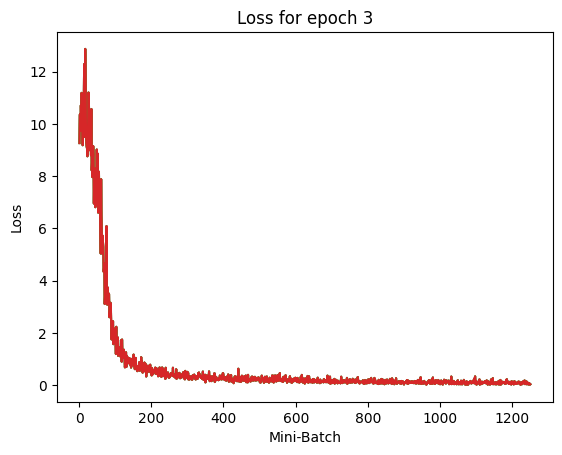

In [46]:
import matplotlib.pyplot as plt

for i in range(0,len(res['loss'])):
    plt.plot(range(1, len(res['loss'][i])+1), res['loss'][0].detach().numpy().reshape(len(res['loss'][i])))
    plt.xlabel("Mini-Batch")
    plt.ylabel("Loss")
    plt.title(f"Loss for epoch {i}")
    plt.savefig(f"./loss_epoch_{i}.png")

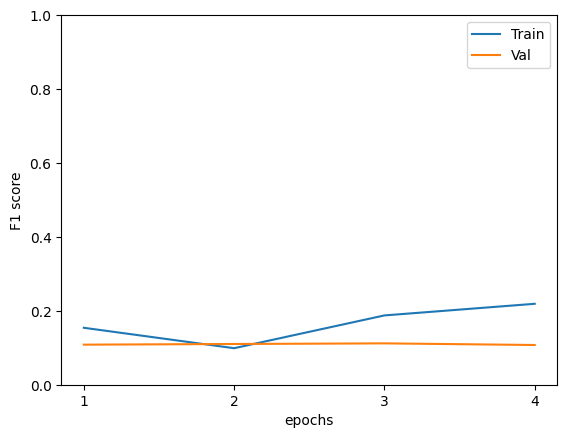

In [10]:
epochs = config['epochs']

plt.plot( range(1,epochs+1), [res['train_score'][i]['rouge']['rouge1']['fmeasure'] for i in range(0, len(res['train_score']))],
        label='Train') 
plt.plot( range(1,epochs+1), [res['val_score'][i]['rouge']['rouge1']['fmeasure'] for i in range(0, len(res['val_score']))],
        label='Val') 
plt.ylim([0, 1])
plt.xlabel('epochs')
plt.ylabel('F1 score')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.savefig('./t5-large.png')

# Get grid results

In [38]:
results = pd.read_csv('task2_grid_results.csv', sep='#')

In [39]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   max_length          92 non-null     int64  
 1   loss                0 non-null      float64
 2   batch_size          92 non-null     int64  
 3   optimizer           92 non-null     object 
 4   lr                  92 non-null     float64
 5   eps                 92 non-null     float64
 6   epochs              92 non-null     int64  
 7   warmup_steps        92 non-null     float64
 8   weight_decay        92 non-null     float64
 9   mode                0 non-null      float64
 10  match_model_type    0 non-null      float64
 11  model_type          92 non-null     object 
 12  train_metrics       92 non-null     object 
 13  validation_metrics  92 non-null     object 
dtypes: float64(7), int64(3), object(4)
memory usage: 10.2+ KB


In [41]:
results.train_metrics

0     [{'rouge': {'rouge1': {'precision': 0.10039630...
1     [{'rouge': {'rouge1': {'precision': 0.08707772...
2     [{'rouge': {'rouge1': {'precision': 0.08014984...
3     [{'rouge': {'rouge1': {'precision': 0.10061315...
4     [{'rouge': {'rouge1': {'precision': 0.23631677...
                            ...                        
87    [{'rouge': {'rouge1': {'precision': 0.15894416...
88    [{'rouge': {'rouge1': {'precision': 0.20541208...
89    [{'rouge': {'rouge1': {'precision': 0.17061319...
90    [{'rouge': {'rouge1': {'precision': 0.14575034...
91    [{'rouge': {'rouge1': {'precision': 0.11104206...
Name: train_metrics, Length: 92, dtype: object

In [44]:
type(results.train_metrics[0])

str

In [60]:
best10 = []
idxbest = []

for i, elem in enumerate(results.validation_metrics):
    res = eval(elem)
    #prendere fmeasure di rouge1
    res = res['rouge']['rouge1']['fmeasure']
    if len(best10) >= 10:
        minimum = min(best10)
        if res > minimum:
            index = best10.index(minimum)
            best10[index] = res
            idxbest[index] = i
    else:
        best10.append(res)
        idxbest.append(i)

In [75]:
best10

[0.15879839500469128,
 0.15012853030506526,
 0.15022028537844268,
 0.15718535078639642,
 0.15010203139597608,
 0.1521299572213119,
 0.15018620742160183,
 0.15038552511804282,
 0.15860736272116935,
 0.15381080565610264]

In [76]:
bestRes = results.iloc[idxbest]

In [77]:
i = 0
for i in range(i, len(bestRes)):
    print("Train")
    print(bestRes.iloc[i]['train_metrics'])
    print("Val")
    print(bestRes.iloc[i]['validation_metrics'])
    print(f"{bestRes.iloc[i]['model_type']} max_l: {bestRes.iloc[i]['max_length']} batch:{bestRes.iloc[i]['batch_size']} lr: {bestRes.iloc[i]['lr']} opt:{bestRes.iloc[i]['optimizer']} eps: {bestRes.iloc[i]['eps']} epochs:{bestRes.iloc[i]['epochs']} wd: {bestRes.iloc[i]['weight_decay']} warmup:{bestRes.iloc[i]['warmup_steps']}")
    print("\n")

Train
[{'rouge': {'rouge1': {'precision': 0.20536540229204026, 'recall': 0.30397059020633366, 'fmeasure': 0.22960817397821273}, 'rouge2': {'precision': 0.11689241352290375, 'recall': 0.1903683437848577, 'fmeasure': 0.13765592356711376}, 'rougeL': {'precision': 0.19918519435811566, 'recall': 0.29428457002736663, 'fmeasure': 0.22242326564280956}, 'rougeLsum': {'precision': 0.1989722223502496, 'recall': 0.2939702841676124, 'fmeasure': 0.22218544841579302}}}, {'rouge': {'rouge1': {'precision': 0.30693650339707285, 'recall': 0.4590588903726647, 'fmeasure': 0.3520106588761448}, 'rouge2': {'precision': 0.21569490274317776, 'recall': 0.3373626879695487, 'fmeasure': 0.25003386942665773}, 'rougeL': {'precision': 0.29887467885203717, 'recall': 0.4469930796161278, 'fmeasure': 0.34291551605608594}, 'rougeLsum': {'precision': 0.2987769796873577, 'recall': 0.4467376835849217, 'fmeasure': 0.3426727485780711}}}]
Val
{'rouge': {'rouge1': {'precision': 0.14315613713391884, 'recall': 0.19004528331974024, 